# CLUSTER EVOLUTION (IN MASS) FROM RELAXATION AND STELLAR EVOLUTION

Import neccessary modules and define the directory where the simulation output is

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmodules import *

datadir = '/home/pdcg/Documents/post_analysis/'
gsl_solver = 'phip_fullicmf/'

G = 6.674e-8 # In cgs cm3 s-2 g-1
kpc = 3.09e21 # in cm
msun = 1.989e33 # in g
gyr = 3.15576e16 # in s

In [2]:
sf = load_subfind(128, dir=datadir+gsl_solver, loadonly=['fpos', 'slty', 'frc2', 'svel', 'sidm', 'smty', 'spos', 'fnsh', 'flty', 'slty', 'ffsh'] )
s = gadget_readsnap(128, snappath=datadir+gsl_solver, subfind=sf, applytransformationfacs=True, hdf5=True)

/home/pdcg/pylib/gadget_subfind.py:443: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('int64'):
/home/pdcg/pylib/gadget_snap.py:707: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


Redshift of the simulation

In [3]:
1/s.time -1 

2.220446049250313e-16

In [4]:
s.calc_sf_indizes(sf)
center = sf.data['spos'][0,:].astype('f8')
rot_matrix = s.select_halo(sf)

galrad= 0.02135690748691559
Found 141250 stars.


In [5]:
s.data['pos'] *= 1e3 # change positions to kiloparsec
s.data['mass'] *= 1e10 # change mass to solar masses
mask_gas = s.data['type']==0
mask_stars = s.data['type']==4
mask_baryons = np.logical_or(mask_gas,mask_stars)
mask_gas_baryons = s.data['type'][mask_baryons]==0
mask_stars_baryons = s.data['type'][mask_baryons]==4
mask_clusters_initial = s.data['incl'] > 0
mask_clusters_final = s.data['nclt'] > 0
mask_clusterst_dptd = s.data['nclt'][mask_clusters_initial] == 0

In [8]:
s.data['r'] = np.sqrt(s.data['pos'][:,0]**2 + s.data['pos'][:,1]**2 + s.data['pos'][:,2]**2)
s.data['l1'] = s.data['tijl'][:,0] * (gyr /(s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s))**2 * s.hubbleparam**2/ s.time**3
s.data['l2'] = s.data['tijl'][:,1] * (gyr /(s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s))**2 * s.hubbleparam**2/ s.time**3
s.data['l3'] = s.data['tijl'][:,2] * (gyr /(s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s))**2 * s.hubbleparam**2/ s.time**3
T_strenght = s.data['l1'] + 1/3 * np.abs(s.data['l1'] + s.data['l2'] + s.data['l3'])

# TIDAL FIELD

In [59]:
clt_disk = (s.data['r']<50) * (np.abs(s.data['pos'][:,2])<2)
# age_mask = (s.cosmology_get_lookback_time_from_a(s.data['age'], is_flat=True)<0.1)

(0.3, 30.0)

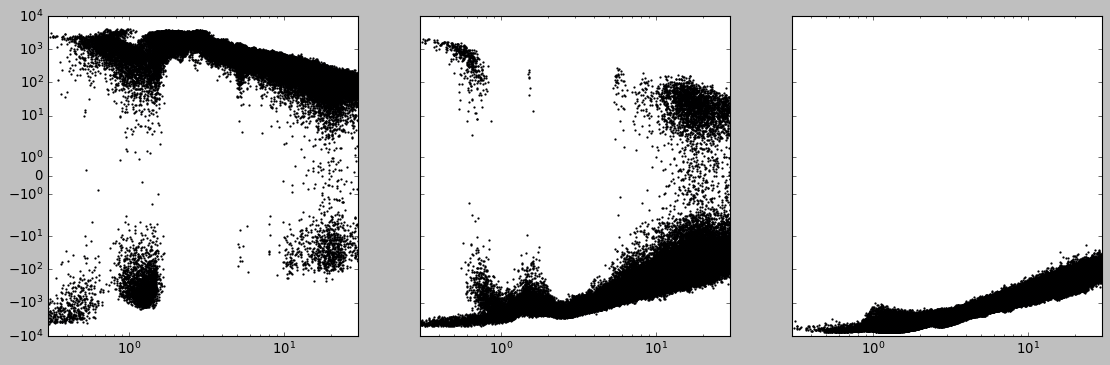

In [60]:
fig, ax = plt.subplots(1, 3 ,figsize=(17,5), sharey=True)
ax[0].scatter(s.data['r'][mask_stars], s.data['l1'][mask_stars], s=1)
ax[1].scatter(s.data['r'][mask_stars], s.data['l2'][mask_stars], s=1)
ax[2].scatter(s.data['r'][mask_stars], s.data['l3'][mask_stars], s=1)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].set_yscale('symlog')
ax[0].set_ylim(-1e4,1e4)
ax[0].set_xlim(3e-1, 3e1)
ax[1].set_xlim(3e-1, 3e1)
ax[2].set_xlim(3e-1, 3e1)

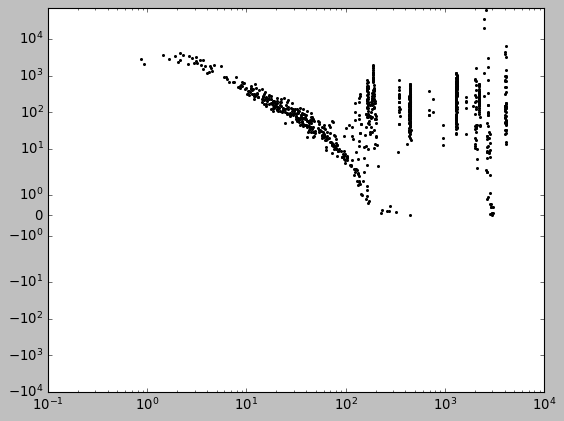

In [61]:
plt.scatter(s.data['r'][mask_stars][mask_clusters_initial], T_strenght[mask_stars][mask_clusters_initial], s=3, c = 'k', edgecolors = 'k')
# plt.scatter(s.data['r'][mask_stars][mask_clusters_initial], T_strenghtb[mask_clusters_initial], s=3, c = 'r', edgecolors = 'r')
# plt.scatter(s.data['r'][mask_stars][mask_clusters_initial], T_strenghtf[mask_clusters_initial], s=3, c = 'b', edgecolors = 'b')
plt.xscale('log')
plt.yscale('symlog')
# plt.xlim(3e-1, 3e1)
# plt.ylim(1e-1, 1e4)

In [62]:
mask = (s.data['r']<50) * (np.abs(s.data['pos'][:,2])<2)
dens_prof = s.get_raddens(nshells=100, mask=mask)

dr set to 0.499972
Calculation took 0.001253s


Test wether the tidal field can be used to estimate physical parameters of the galaxies in the simulations. First, see if it can be used to estimate the density profile

In [63]:
dens_prof_est = np.abs(s.data['l1'] + s.data['l2'] + s.data['l3'])/gyr**2/(4*np.pi*G)
dens_prof_est *= (kpc**3)/(msun)

/tmp/ipykernel_64640/604486013.py:1: RuntimeWarning: invalid value encountered in add
  dens_prof_est = np.abs(s.data['l1'] + s.data['l2'] + s.data['l3'])/gyr**2/(4*np.pi*G)


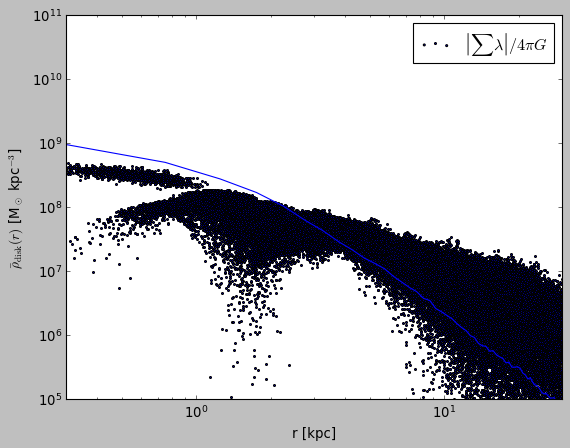

In [64]:
plt.scatter(s.data['r'][mask_stars], dens_prof_est[mask_stars], s=3, label=r'$\left| \sum{\lambda}\right| / 4 \pi G$')
plt.plot(dens_prof[1,:], dens_prof[0,:])
plt.xscale('log')
plt.yscale('symlog')
plt.ylim(1e5, 1e11)
plt.xlim(3e-1, 3e1)
plt.legend()
plt.xlabel("r [kpc]")
plt.ylabel(r"$\bar{\rho}_\mathrm{disk} (r)$ [M$_\odot$ kpc$^{-3}$]")
plt.savefig('avedens_tidal.png')

Test if it can be used to trace the circular velocity

In [65]:
circ_vel_est = np.sqrt(1/3 * np.abs(s.data['l1'] + s.data['l2'] + s.data['l3']))

/tmp/ipykernel_64640/1652258464.py:1: RuntimeWarning: invalid value encountered in add
  circ_vel_est = np.sqrt(1/3 * np.abs(s.data['l1'] + s.data['l2'] + s.data['l3']))


In [66]:
rad_massprof = s.get_radmassprof(nshells=100000, mask=mask)
enclosed_mass = rad_massprof[0,:] * msun
rad = rad_massprof[1,:] * kpc
circ_vel = np.sqrt(G*enclosed_mass/(rad**3))*gyr # [Gyr-1]

dr set to 0.000499972
Calculation took 0.003058s


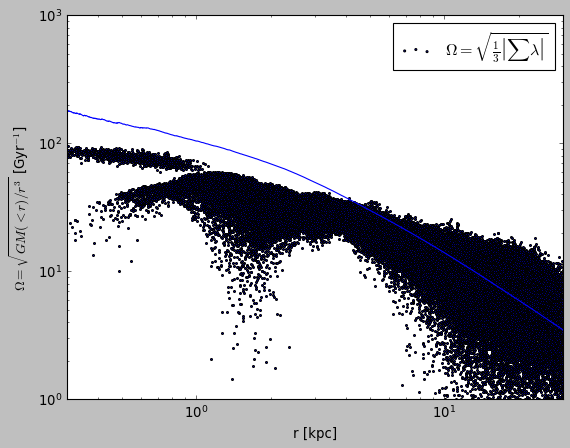

In [67]:
plt.scatter(s.data['r'][mask_stars], circ_vel_est[mask_stars], s=3, label=r'$\Omega = \sqrt{\frac{1}{3}\left| \sum{\lambda}\right|}$')
plt.loglog(rad/3.086e21, circ_vel)
plt.xlim(3e-1, 3e1)
plt.ylim(1e0, 1e3)
plt.legend()
plt.xlabel("r [kpc]")
plt.ylabel(r"$\Omega = \sqrt{GM(<r)/r^3}$ [Gyr$^{-1}$]")
plt.savefig('circvel_tidal.png')

Lastly, test if it traces the epicyclic frequency

In [68]:
kappa = np.sqrt(7 * G * enclosed_mass / rad**3) * gyr
kappa_est = np.sqrt(np.abs(3*circ_vel_est**2 - s.data['l1']))

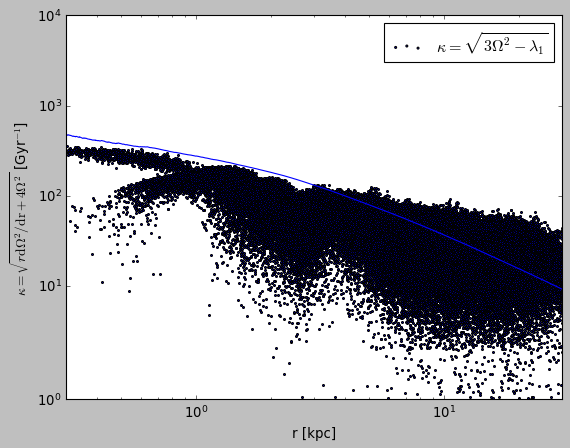

In [69]:
plt.scatter(s.data['r'][mask_stars], 2*kappa_est[mask_stars], s=3, label=r'$\kappa = \sqrt{3\Omega^2 - \lambda_1}$')
plt.plot(rad/3.086e21, kappa)
plt.yscale('symlog')
plt.xscale('log')
plt.xlim(3e-1,3e1)
plt.ylim(1e0,1e4)
plt.legend()
plt.xlabel("r [kpc]")
plt.ylabel(r"$\kappa = \sqrt{r \rm{d}\Omega^2/\rm{d}r + 4\Omega^2}$ [Gyr$^{-1}$]")
plt.savefig('epyciclic_tidal.png')

Same pipeline but with pynbody

In [70]:
import pynbody

In [71]:
s = pynbody.load(datadir+gsl_solver+'snapdir_127/snapshot_127')

/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/snapshot/gadgethdf.py:370: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


In [72]:
h = s.halos()

In [73]:
pynbody.analysis.halo.center(h[1], mode='hyb')

In [74]:
s.physical_units()

In [75]:
s['r'] = np.sqrt(s['x']**2 + s['y']**2 + s['z']**2)

In [76]:
s['Tij'] = s['TIJ_Eigenvalues'] * (gyr /(s.properties['UnitLength_in_cm']/s.properties['UnitVelocity_in_cm_per_s']))**2 * s.properties['h']**2/ s.properties['a']**3
s['T'] = s['Tij_x'] + 1/3*np.abs(s['Tij_x'] + s['Tij_y'] + s['Tij_z'])

/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/snapshot/gadgethdf.py:394: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")
/home/pdcg/anaconda3/lib/python3.9/site-packages/pynbody/array.py:434: RuntimeWarning: invalid value encountered in add
  r = add_op(self, x)


In [77]:
p = pynbody.analysis.profile.Profile(s.d, ndim=3, min=0.01, max= 50)

In [78]:
s.d['eps'] = s.d['smooth']

In [79]:
circ_vel_est = np.sqrt(1/3 * np.abs(s.s['Tij_x'] + s.s['Tij_y'] + s.s['Tij_z']))
kappa_est = np.sqrt(np.abs(3*circ_vel_est**2 - s.s['Tij_x']))

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


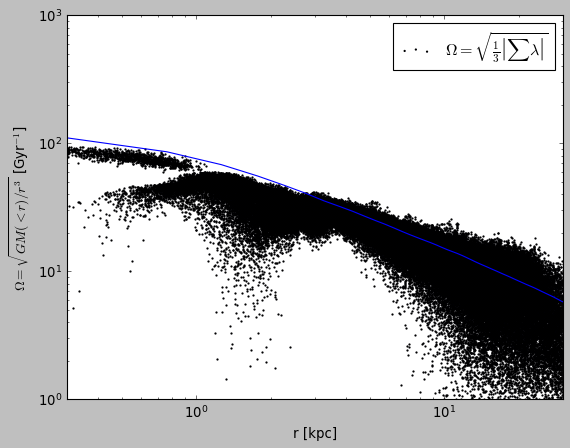

In [80]:
plt.loglog(p['rbins'], p['omega'])
plt.scatter(s.s['r'], circ_vel_est, s=1, label=r'$\Omega = \sqrt{\frac{1}{3}\left| \sum{\lambda}\right|}$')
plt.xlim(3e-1, 3e1)
plt.ylim(1e0, 1e3)
plt.legend()
plt.xlabel("r [kpc]")
plt.ylabel(r"$\Omega = \sqrt{GM(<r)/r^3}$ [Gyr$^{-1}$]")
plt.savefig('circvel_tidal.png')

In [81]:
dens_prof_est = np.abs(s.s['Tij_x'] + s.s['Tij_y'] + s.s['Tij_z'])/(4 * np.pi * G * gyr**2)
dens_prof_est *= (kpc**3)/(msun)

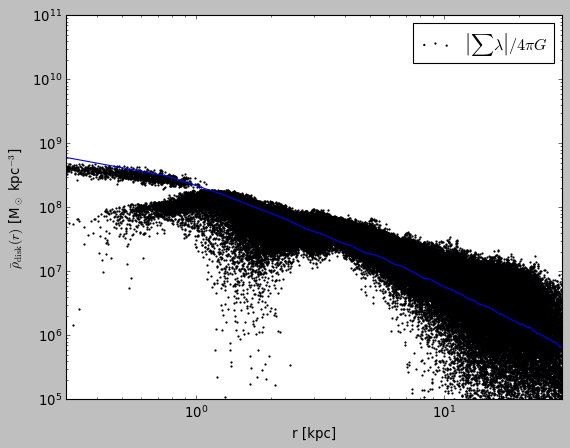

In [82]:
plt.plot(p['rbins'], p['density'])
plt.scatter(s.s['r'], dens_prof_est, s=1, label=r'$\left| \sum{\lambda}\right| / 4 \pi G$')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e5, 1e11)
plt.xlim(3e-1, 3e1)
plt.xlabel("r [kpc]")
plt.ylabel(r"$\bar{\rho}_\mathrm{disk} (r)$ [M$_\odot$ kpc$^{-3}$]")
plt.legend()
plt.savefig('avedens_tidal.png')

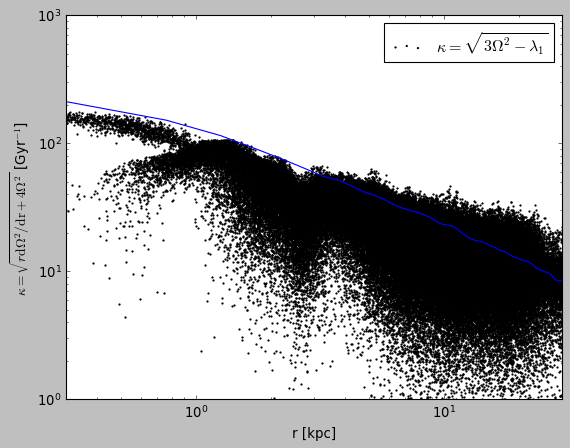

In [84]:
plt.scatter(s.s['r'], kappa_est, s=1, label=r'$\kappa = \sqrt{3\Omega^2 - \lambda_1}$')
plt.loglog(p['rbins'], p['kappa'])
plt.xlim(3e-1,3e1)
plt.ylim(1e0,1e3)
plt.legend()
plt.xlabel("r [kpc]")
plt.ylabel(r"$\kappa = \sqrt{r \rm{d}\Omega^2/\rm{d}r + 4\Omega^2}$ [Gyr$^{-1}$]")
plt.savefig('epyciclic_tidal.png')

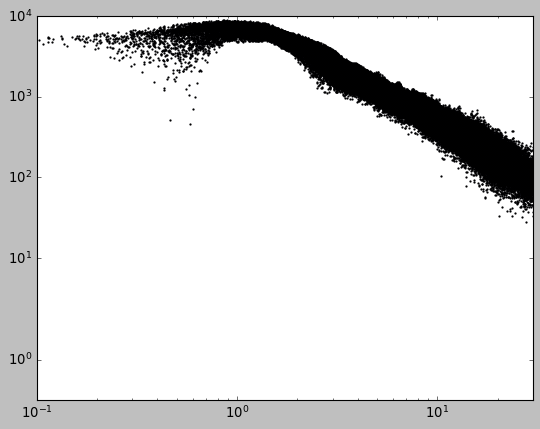

In [29]:
plt.scatter(s.s['r'], s.s['T'], s=1)
plt.yscale('symlog')
plt.ylim(1e-1, 1e4)
plt.xlim(1e-1, 3e1)
plt.xscale('log')